In [1]:
#imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
#camera calibration
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
    
def cameracalibrate(path):
        
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) 

    nx = 9
    ny = 6
    # Make a list of calibration images
    images = glob.glob(path)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'corners_found'+str(idx)+'.jpg'
            output = 'output_images/corners/' + write_name
            cv2.imwrite(output, img)            

In [3]:
def undistortimage(path):
    #Undistort test images of the lane lines provided
    test_images = glob.glob(path)
    
    for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        img_size = (img.shape[1], img.shape[0])
        # Do camera calibration given object points and image points
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        write_f = 'undistorted_test'+str(idx)+'.jpg'
        out = 'output_images/undistorted/' + write_f
        cv2.imwrite(out,dst)
 
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(dst)
        ax2.set_title('Undistorted Image', fontsize=30)

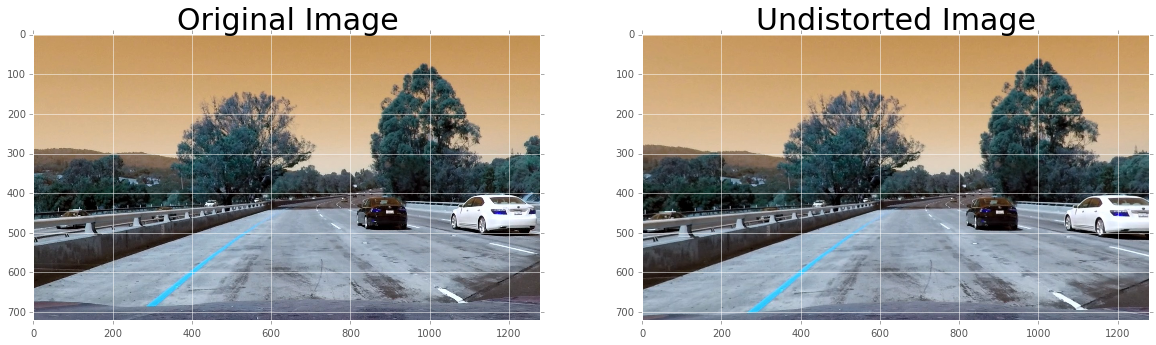

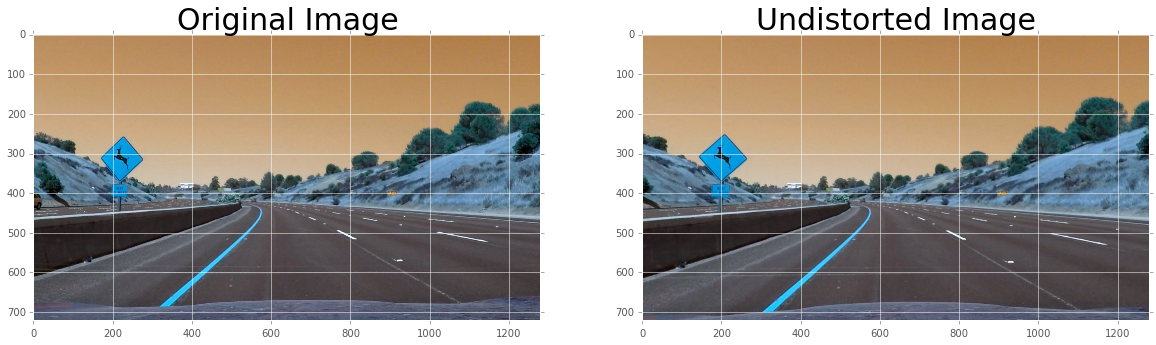

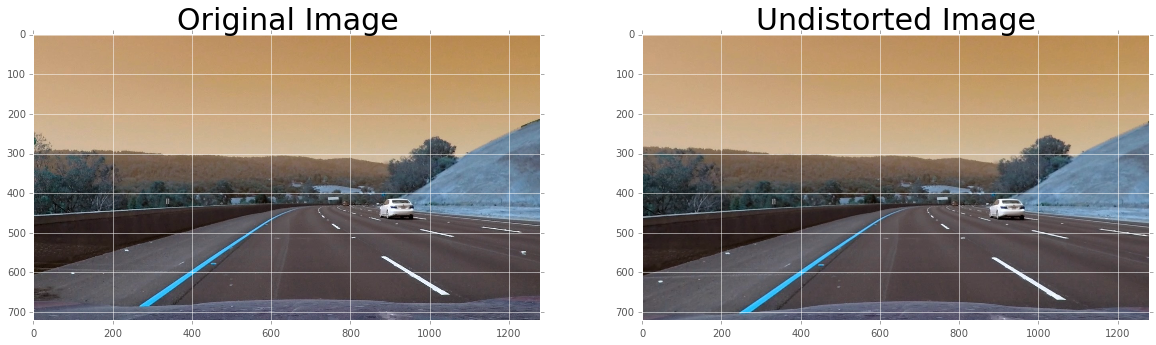

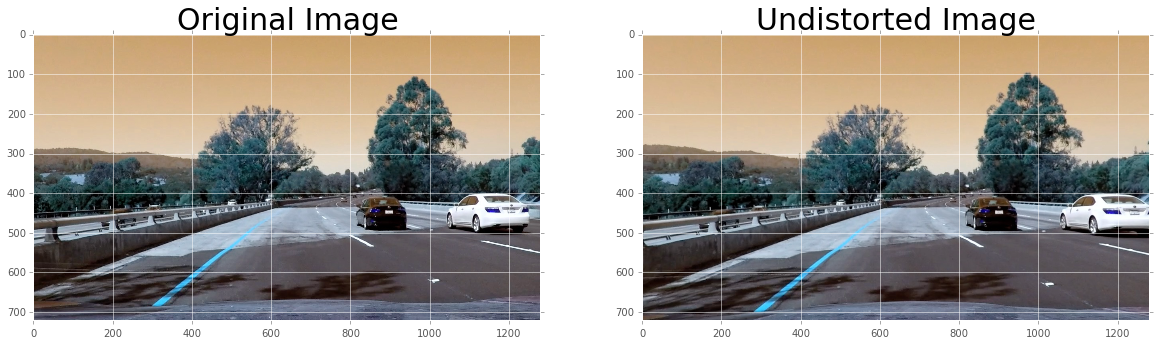

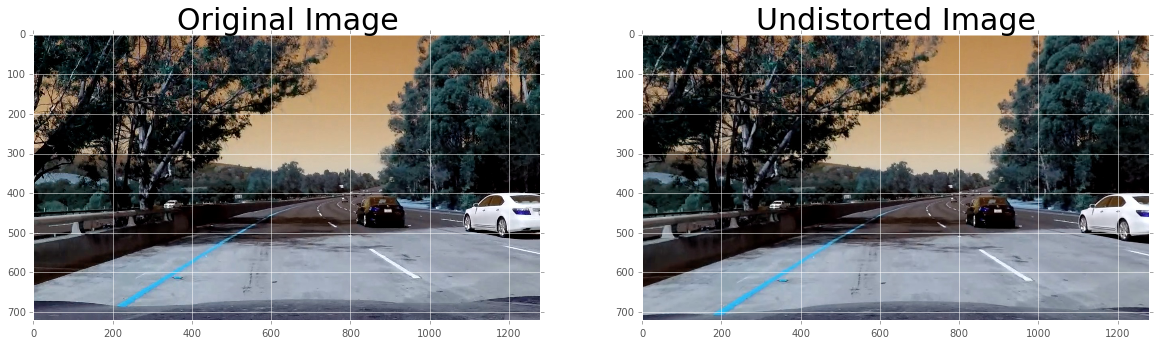

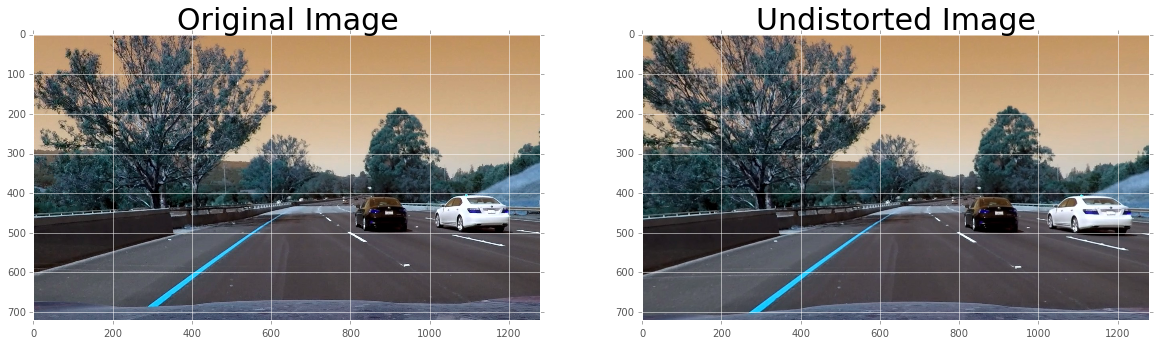

In [4]:
cameracalibrate('camera_cal/calibration*.jpg')
undistortimage('test_images/test*.jpg')

In [27]:
#apply sobel thresholding
def sobel_thresholding(img, sobel_kernel=3, mag_thresh=(70,210)):
    # Apply the following steps to img
    mod = img.copy()
    #mask image
    mod[0:370,0:1400] = 0
    gray = cv2.cvtColor(mod,cv2.COLOR_RGB2GRAY)
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    #absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    mag = np.sqrt((abs_sobel_x*abs_sobel_x) + (abs_sobel_y*abs_sobel_y))
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_sobel)    
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

In [28]:
def color_thresholding(img, col_threshold=(150,220)):    
    mod = img.copy()
    #mask image
    mod[0:370,0:1400] = 0
    
    hls = cv2.cvtColor(mod, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > col_threshold[0]) & (S <= col_threshold[1])] = 1
    '''
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(H, cmap='gray')
    ax2.set_title('H', fontsize=25)
    ax3.imshow(L, cmap='gray')
    ax3.set_title('L', fontsize=25)
    ax4.imshow(S, cmap='gray')
    ax4.set_title('S', fontsize=25)
    ax5.imshow(binary, cmap='gray')
    ax5.set_title('Threshold S', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    '''
    return binary

In [29]:
def get_source_points(img):
        img_size = (img.shape[1], img.shape[0])
              
        source_points = np.float32(
           [[(img_size[0] / 2) + 100, img_size[1] / 2 + 100], #top right
            [(img_size[0] * 5 / 6) + 60, img_size[1]],    #bottom right 
            [(img_size[0] / 6 + 30), img_size[1]],  #bottom left
            [(img_size[0] / 2 -40), img_size[1] / 2 + 100] #top left           
            ]) 
        return source_points

   
def get_dest_points(img):
        img_size = (img.shape[1], img.shape[0])
        destination_points = np.float32(
            [[(img_size[0] * 5 / 6) + 60,0], # top right
            [(img_size[0] * 5 / 6) + 60,  img_size[1]], # bottom right 
            [(img_size[0] / 6 + 30),  img_size[1]], # bottom left
            [(img_size[0] / 6 + 30), 0] #top left
            ]) 
        return destination_points

In [54]:
def radius_curv(originalimage, binary_warped, inverseM):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    '''
    plt.subplots(1, 1, figsize=(10, 9))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
      # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    # write the warped image
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((binary_warped, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inverseM, (originalimage.shape[1], originalimage.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(originalimage, 1, newwarp, 0.3, 0)
    
    left_text = 'Left Curvature : ' + str(left_curverad)
    right_text = 'Right Curvature : ' + str(right_curverad)
    #write text on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, left_text, (20,50), font, 1, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(result, right_text, (20,100), font, 1, (200,255,155), 2, cv2.LINE_AA)
    plt.subplots(1, 1, figsize=(10, 9))
    plt.imshow(result)

In [55]:
def warp(originalimage, thresholdedimg, idx):

    image_size = (thresholdedimg.shape[1], thresholdedimg.shape[0])
    src = get_source_points(thresholdedimg)
    dst = get_dest_points(thresholdedimg)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(thresholdedimg, M, image_size, flags=cv2.INTER_LINEAR)
    #convert image back to grayscale as perpective transform changes it to color
    warped_gray = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
    write_thr = 'source_pers'+str(idx)+'.jpg'
    out = 'output_images/perspective/' + write_thr
    cv2.imwrite(out,warped_gray)
     
    '''    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)    
    cv2.line(image, (src[0][0],src[0][1]),(src[1][0],src[1][1]), (255,0,0),5)
    cv2.line(image, (src[2][0],src[2][1]),(src[3][0],src[3][1]), (255,0,0),5)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped)
    cv2.line(warped, (dst[0][0],dst[0][1]),(dst[1][0],dst[1][1]), (255,0,0),5)
    cv2.line(warped, (dst[2][0],dst[2][1]),(dst[3][0],dst[3][1]), (255,0,0),5)
    ax2.set_title('Perpective transform', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    '''
    
    radius_curv(originalimage, warped_gray, Minv)


806.89543681 m 1040.58214122 m
501.270792554 m 316.829446248 m
864.073918247 m 831.656600277 m
1044.26561894 m 1505.05630552 m
445.006130595 m 819.030956594 m
838.981779208 m 1020.00405844 m


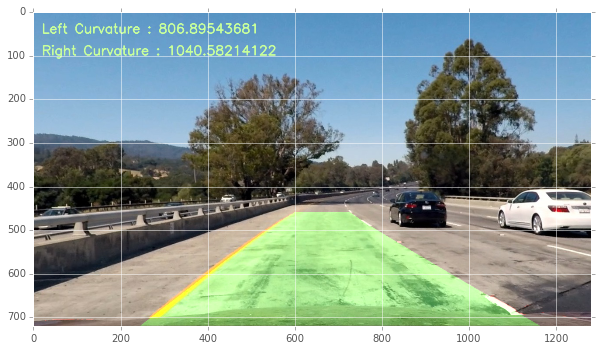

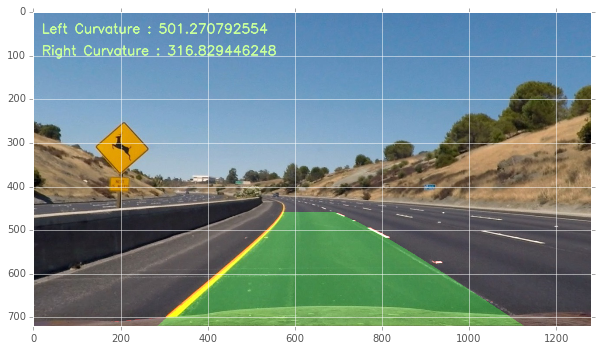

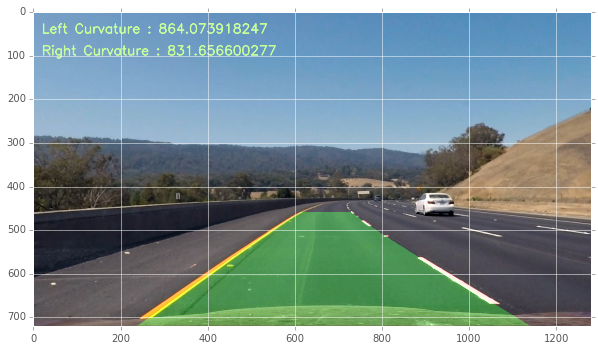

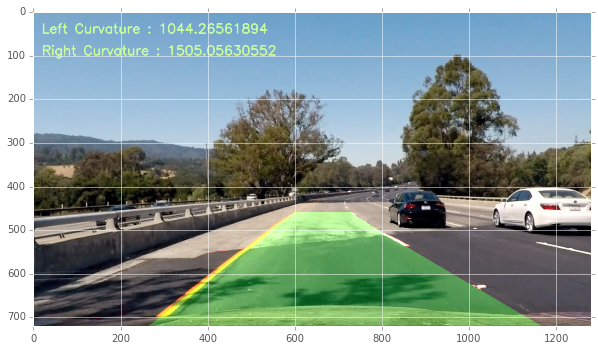

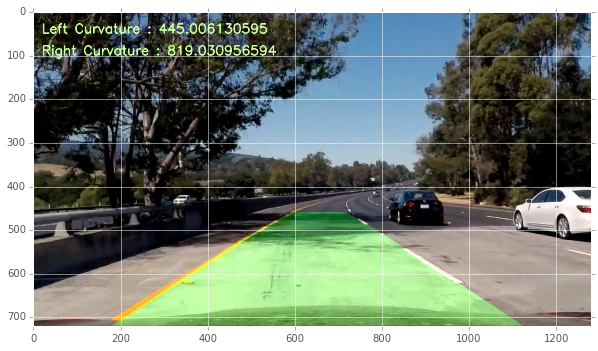

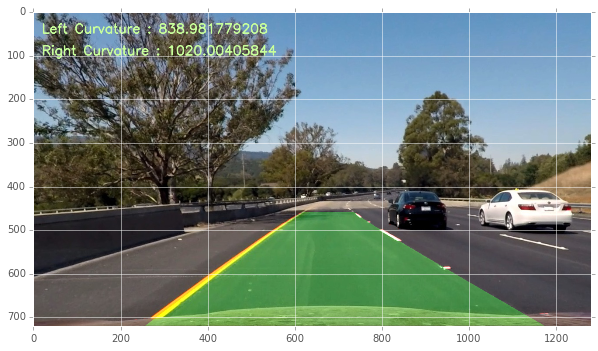

In [56]:
undis_images = glob.glob('output_images/undistorted/undistorted*.jpg')
for idx, fname in enumerate(undis_images):   
    image = mpimg.imread(fname)
    # apply magnitude thresholding
    mag_binary = sobel_thresholding(image, sobel_kernel=3, mag_thresh=(70, 210))

    #apply color thresholding on S in HLS image
    col_binary = color_thresholding(image, col_threshold=(150,220))

    #combine the results of magnitude thresholding and color thresholding
    combined_binary = np.zeros_like(col_binary)

    combined_binary[(mag_binary | col_binary) == 1] = 1

    #plt.imshow(mag_binary, cmap="gray")
    new_img = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    write_thr = 'thresholded'+str(idx)+'.jpg'
    out = 'output_images/threshold/' + write_thr
    cv2.imwrite(out,new_img)
   
    '''
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined_binary)
    ax2.set_title('Binary Thresholding', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    '''
    #apply warping
    warp(image, new_img, idx)